# Thème 3: Aménagement cyclable/apaisement
**Correspondance cartographique :** densité point rouge_58 / vert_60 x type de voirie (Données Route 500) 
- Identifier la part des points rouges situées à moins de 50 mètres de voies / carrefours routières 
- La majorité des points rouges se situe sur des infrastructures routières complexes (voies structurantes / carrefour routier) 

> Hypothèse : Il faut transformer les infrastructures automobiles structurantes pour sécuriser la pratique des cyclistes

**Consignes supplémentaires :** Initialement l'idée était de faire ça avec les points uniques mais faire cela à partir des concentrations de points que tu as identifié sera sans doute plus pertinent.<br/>

identifier pour chaque cluster (vert / rouge) :
1. sur quels types de voirie il se situe (oui ou non présent sur un gros axe)
2. Et voir s'il y a une corrélation 

(on retrouve un lien entre cluster rouge & liaison à vocation régionale/nationale là où on a des infra de route les plus importantes les points les plus dangereux car ce n'est pas adaptée)
!= points verts --> liaisons locales (car c'est aménagés)


NB_VOIES --> danger car voie trop grande ??? 


Livrable : tableau + graphique + correlation ou pas

Cluster contient un carrefour ? --> typologie du carrefour lien entre la présence d'un carrefour et la présence d'un cluster ? 

## Python stuff

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
from s3_utils import S3Manager
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact

# Configs
_ = plt.style.use("ggplot")

In [2]:
s3_manager = S3Manager()
bucket = "fub-s3"

## 1 - Récupération et préparation des données

### 1.1 - Clusters en entrée

In [3]:
gdf_58 = gpd.read_file("temp/cluster_cat_58.geojson")
gdf_60 = gpd.read_file("temp/cluster_cat_60.geojson")

In [4]:
# Infos rapides sur les datasets 
print(gdf_58.crs if gdf_60.crs == gdf_58.crs else "Les CRS sont différents uniformiser les données")
gdf_58.head(3)

EPSG:4326


,cluster_id,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points,geometry
0,0,261dbaa4-2555-40b2-a627-cb7c0d947172,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,89,554,16.06,"POLYGON ((2.31115 48.8156, 2.31105 48.81604, 2..."
1,1,8489e10a-8434-4d03-8161-a0606c67f44b,58,d9bfec3d-fef7-47c9-b949-60964467556f,,92049,Montrouge,109,554,19.68,"POLYGON ((2.31914 48.81765, 2.3185 48.8187, 2...."
2,2,8f6e0b77-2819-435e-a910-ceb2905e89ae,58,edf78d17-34e7-4c6a-879b-a3f298e67105,Grand échangeur,69199,Saint-Fons,24,37,64.86,"POLYGON ((4.85501 45.71655, 4.85466 45.71659, ..."


### 1.2 - Données d'enrichissement

In [5]:
# Téléchargement des fichiers depuis S3
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.COMMUNICATION_RESTREINTE.fgb", "temp/COMMUNICATION_RESTREINTE.fgb")
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.NOEUD_COMMUNE.fgb", "temp/NOEUD_COMMUNE.fgb")
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.NOEUD_ROUTIER.fgb", "temp/NOEUD_ROUTIER.fgb")
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.B.TRONCON_ROUTE.fgb", "temp/TRONCON_ROUTE.fgb")

✅ Fichier téléchargé depuis S3 : temp/COMMUNICATION_RESTREINTE.fgb
✅ Fichier téléchargé depuis S3 : temp/NOEUD_COMMUNE.fgb
✅ Fichier téléchargé depuis S3 : temp/NOEUD_ROUTIER.fgb
✅ Fichier téléchargé depuis S3 : temp/TRONCON_ROUTE.fgb


In [6]:
# communication_restreinte = gpd.read_file("temp/COMMUNICATION_RESTREINTE.fgb") # ignoré
# noeud_commune = gpd.read_file("temp/NOEUD_COMMUNE.fgb") # doublon spatial avec noeud_routier
noeud_routier = gpd.read_file("temp/NOEUD_ROUTIER.fgb")
troncon_route = gpd.read_file("temp/TRONCON_ROUTE.fgb")

## 2 - Croisement tronçon routier

### 2.1 - Points rouges 58

#### 2.1.1 - Statistiques globales 

In [7]:
# Ignorer les tronçons de type autoroutier
troncon_route = troncon_route[troncon_route["VOCATION"] != 'Type autoroutier']
troncon_route.VOCATION.unique()

array(['Liaison locale', 'Liaison principale', 'Liaison régionale',
       'Bretelle'], dtype=object)

In [8]:
gdf_58_2154 = gdf_58.to_crs(epsg=2154).copy()
troncon_route_2154 = troncon_route.to_crs(epsg=2154).copy()
print(f"Projections : {gdf_58_2154.crs}" if gdf_58_2154.crs == gdf_58_2154.crs else "Les CRS sont différents uniformiser les données")
print(f"gdf_58 : {gdf_58_2154.shape[0]} lignes | troncon_route : {troncon_route_2154.shape[0]} lignes")

Projections : EPSG:2154
gdf_58 : 2554 lignes | troncon_route : 273808 lignes


In [9]:
cross_route = gpd.sjoin_nearest(
    gdf_58_2154,
    troncon_route_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="troncon",
    distance_col="dist_m"
)

In [10]:
nb_point_58 = gdf_58.shape[0]
cross_58 = cross_route[cross_route["index_troncon"].notnull()].copy()
cluster_crossed = float(round(cross_58.drop_duplicates('cluster_id').shape[0] / nb_point_58 * 100, 2))
unique_clusters = cross_58.drop_duplicates('cluster_id').shape[0]

In [11]:
print("---"*3, "Résultats", "---"*3)
print(f"- Taille du croisement avec 50m : {cross_58.shape[0]}") 
print(f"- {cluster_crossed} % des clusters ({unique_clusters}/{gdf_58_2154.shape[0]}) se situent à moins de 50 mètres d’une voie")

--------- Résultats ---------
- Taille du croisement avec 50m : 6285
- 93.74 % des clusters (2394/2554) se situent à moins de 50 mètres d’une voie


#### 2.1.2 - Caractérisation des jointures

In [12]:
c_route = cross_route[cross_route["index_troncon"].notnull()]
cross_data_58 = c_route.groupby("VOCATION").size().reset_index(name='counts').sort_values(by='counts', ascending=False)
cross_data_58

,VOCATION,counts
3,Liaison régionale,2686
2,Liaison principale,2234
1,Liaison locale,1363
0,Bretelle,2


In [13]:
cross_data_58_2 = c_route.groupby("NB_VOIES").size().reset_index(name='counts').sort_values(by='counts', ascending=False)
cross_data_58_2

,NB_VOIES,counts
0,1 voie ou 2 voies étroites,4209
1,2 voies larges,898
5,Sans objet,755
2,3 voies,240
3,4 voies,174
4,Plus de 4 voies,9


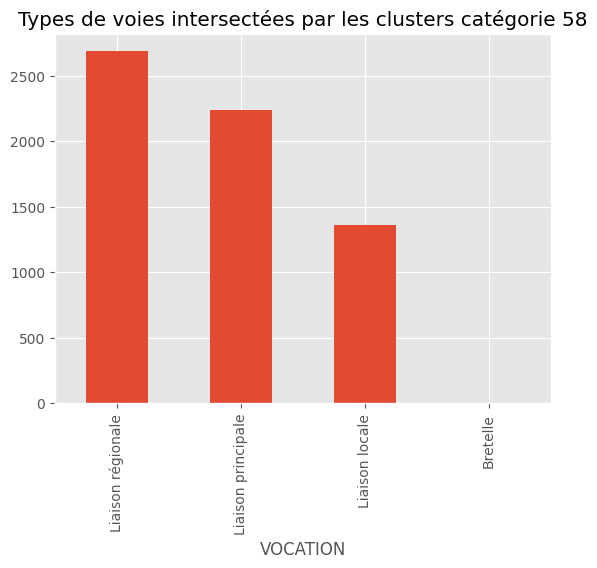

In [14]:
_ = cross_data_58.plot.bar(
    x='VOCATION', y='counts', 
    legend=False, title="Types de voies intersectées par les clusters catégorie 58"
) 

### 2.2 - Points verts 60

In [15]:
gdf_60_2154 = gdf_60.to_crs(epsg=2154).copy()
troncon_route_2154 = troncon_route.to_crs(epsg=2154).copy()
print(f"Projections : {gdf_60_2154.crs}" if gdf_60_2154.crs == gdf_60_2154.crs else "Les CRS sont différents uniformiser les données")
print(f"gdf_60 : {gdf_60_2154.shape[0]} lignes | troncon_route : {troncon_route_2154.shape[0]} lignes")

Projections : EPSG:2154
gdf_60 : 930 lignes | troncon_route : 273808 lignes


In [16]:
cross_route_2 = gpd.sjoin_nearest(
    gdf_60_2154,
    troncon_route_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="troncon",
    distance_col="dist_m"
)

In [17]:
nb_point_60 = gdf_60.shape[0]
cross_60 = cross_route_2[cross_route_2["index_troncon"].notnull()].copy()
cluster_crossed = float(round(cross_60.drop_duplicates('cluster_id').shape[0] / nb_point_60 * 100, 2))
unique_clusters = cross_60.drop_duplicates('cluster_id').shape[0]

In [18]:
print("---"*3, "Résultats", "---"*3)
print(f"- Taille du croisement avec 50m : {cross_60.shape[0]}") 
print(f"- {cluster_crossed} % des clusters ({unique_clusters}/{gdf_60_2154.shape[0]}) se situent à moins de 50 mètres d’une voie")

--------- Résultats ---------
- Taille du croisement avec 50m : 1569
- 85.38 % des clusters (794/930) se situent à moins de 50 mètres d’une voie


In [19]:
c_route = cross_route_2[cross_route_2["index_troncon"].notnull()]
cross_data_60 = c_route.groupby("VOCATION").size().reset_index(name='counts').sort_values(by='counts', ascending=False)
cross_data_60

,VOCATION,counts
2,Liaison régionale,748
1,Liaison principale,450
0,Liaison locale,371


In [20]:
cross_data_60_2 = c_route.groupby("NB_VOIES").size().reset_index(name='counts').sort_values(by='counts', ascending=False)
cross_data_60_2

,NB_VOIES,counts
0,1 voie ou 2 voies étroites,1105
5,Sans objet,176
1,2 voies larges,163
2,3 voies,64
3,4 voies,58
4,Plus de 4 voies,3


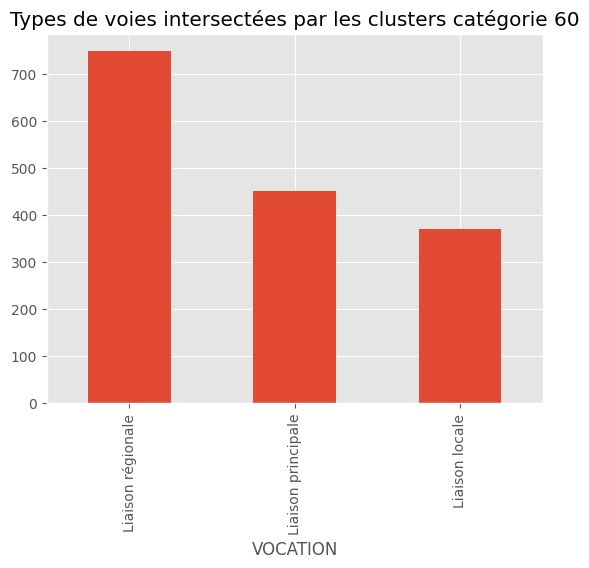

In [21]:
_ = cross_data_60.plot.bar(
    x='VOCATION', y='counts', 
    legend=False, title="Types de voies intersectées par les clusters catégorie 60"
) 

## 3 - Test statistiques

In [22]:
red = (cross_route[cross_route["index_troncon"].notnull()]
       .drop_duplicates("cluster_id")[["cluster_id","VOCATION"]]).copy()
green = (cross_route_2[cross_route_2["index_troncon"].notnull()]
         .drop_duplicates("cluster_id")[["cluster_id","VOCATION"]]).copy()

In [23]:
cnt_red = red["VOCATION"].value_counts()
cnt_green = green["VOCATION"].value_counts()
cont = pd.DataFrame({"Rouge": cnt_red, "Vert": cnt_green}).T.fillna(0).astype(int)
print("Table de contingence (clusters à ≤50 m) :")
cont

Table de contingence (clusters à ≤50 m) :


VOCATION,Liaison régionale,Liaison principale,Liaison locale
Rouge,1041,826,527
Vert,360,248,186


In [24]:
chi2, p_chi2, dof, expected = chi2_contingency(cont.values)
print(f"Chi² global = {chi2:.3f} (ddl={dof}) | p-value = {p_chi2:.4g}")

Chi² global = 2.890 (ddl=2) | p-value = 0.2357


In [25]:
n = cont.values.sum()
r, k = cont.shape
phi2 = chi2 / n
cramers_v = np.sqrt(phi2 / min(k-1, r-1))
print(f"V de Cramér = {cramers_v:.3f}\n")

V de Cramér = 0.030



In [26]:
std_res = (cont.values - expected) / np.sqrt(expected)
res_df = pd.DataFrame(std_res, index=cont.index, columns=cont.columns)
print("Résiduels standardisés (>|2| ≈ contribution notable) :")
res_df

Résiduels standardisés (>|2| ≈ contribution notable) :


VOCATION,Liaison régionale,Liaison principale,Liaison locale
Rouge,-0.341242,0.686265,-0.363926
Vert,0.592535,-1.191636,0.631925


In [27]:
def fisher_on_category(cat, alternative):
    a = cont.loc["Rouge", cat]
    b = cont.loc["Rouge"].sum() - a
    c = cont.loc["Vert", cat]
    d = cont.loc["Vert"].sum() - c
    odds, p = fisher_exact([[a, b], [c, d]], alternative=alternative)
    return odds, p, a, b, c, d

In [28]:
if "Liaison régionale" in cont.columns or 3 in cont.columns:
    cat_reg = "Liaison régionale" if "Liaison régionale" in cont.columns else 3
    odds_reg, p_reg, a,b,c,d = fisher_on_category(cat_reg, "greater")
    print(f"[Fisher] Part 'régionale' Rouge > Vert : OR={odds_reg:.3f} | p={p_reg:.4g} "
          f"(Rouge: {a}/{a+b}, Vert: {c}/{c+d})")

[Fisher] Part 'régionale' Rouge > Vert : OR=0.928 | p=0.8301 (Rouge: 1041/2394, Vert: 360/794)


In [ ]:
if "Liaison locale" in cont.columns or 1 in cont.columns:
    cat_loc = "Liaison locale" if "Liaison locale" in cont.columns else 1
    odds_loc, p_loc, a,b,c,d = fisher_on_category(cat_loc, "less")
    print(f"[Fisher] Part 'locale' Rouge < Vert : OR={odds_loc:.3f} | p={p_loc:.4g} "
          f"(Rouge: {a}/{a+b}, Vert: {c}/{c+d})")

[Fisher] Part 'locale' Rouge < Vert : OR=0.923 | p=0.2176 (Rouge: 527/2394, Vert: 186/794)


## Conclusion

Les analyses montrent que les clusters rouges (zones à risque) comme les clusters verts (zones aménagées) sont très majoritairement situés à proximité immédiate du réseau routier :
- 93,7 % des clusters rouges et 85,4 % des clusters verts se trouvent à moins de 50 mètres d’une voie.

Cependant, les tests statistiques ne confirment pas que les clusters rouges soient significativement plus associés aux axes régionaux/nationaux que les clusters verts :
- La distribution des types de liaisons (régionales, principales, locales) est globalement similaire entre les deux catégories.

De même, la largeur des voies (1-2 voies étroites, 3-4 voies, >4 voies) ne révèle pas d’écart significatif : la majorité des intersections pour les deux types concerne des routes étroites à deux voies, avec une part plus faible mais comparable sur des infrastructures plus larges.